# Klinični zapisi srčnega popuščanja – Projekt podatkovne znanosti

Ta Jupyter zvezek dokumentira vse analitične korake projekta, ki temelji na podatkovni zbirki:

📁 `heart_failure_clinical_records_dataset.csv`

---

##  Cilj projekta

Cilj projekta je analizirati in modelirati zdravstvene podatke, povezane s srčnim popuščanjem. Končni cilj je zgraditi **Bayesovo mrežo**, ki podpira napovedovanje tveganja in sprejemanje medicinskih odločitev.

Projekt je razdeljen na dva dela:
1. **Analiza kakovosti podatkov in enospremenljivna analiza** (ta zvezek)
2. **Izgradnja in vrednotenje Bayesove mreže** (v programu GeNIe, razloženo v Wordu in priloženo v ZIP datoteki)

---

##  Opis podatkovne zbirke

Podatkovna zbirka vsebuje 299 zapisov pacientov s 13 spremenljivkami, povezanimi s kliničnimi parametri in izidom srčnega popuščanja.

Vsaka vrstica predstavlja enega pacienta in vključuje:
- Demografske podatke (npr. starost, spol)
- Laboratorijske vrednosti (npr. serumski natrij, kreatinin, trombociti)
- Klinične pokazatelje (npr. ejekcijska frakcija, anemija)
- **Ciljna spremenljivka**: `DEATH_EVENT` (1 = smrt med spremljanjem, 0 = preživetje)

Vir: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records)

---

##  Ta zvezek vključuje:

### **1. del: Analiza kakovosti podatkov**
- Manjkajoče vrednosti (izračun in komentar)
- Ekstremne vrednosti z uporabo Z-ocen (z razlago)
- Min-Max transformacija (in komentar o koncentraciji in merilu)
- Porazdelitev vsake spremenljivke (histogrami in opombe)
- Statistični ukrepi:
  - Povprečje, mediana
  - Asimetrija (α3), sploščenost (α4)
  - Standardni odklon, varianca
- Ustvarjanje ali razlaga ciljne spremenljivke, če je potrebno
- Strokovni komentarji in zaključki za vsak korak

### **2. del: Enospremenljivna analiza**
- Teža dokazov (Weight of Evidence - WoE) in informacijska vrednost (Information Value - IV)
- Izbor najbolj napovednih spremenljivk
- Groba razvrstitev z uporabo WoE
- Zgodborisje: razumevanje medicinskega in napovednega pomena

### **3. del: Razvoj Bayesove mreže (v GeNIe)**
- Priprava modela z uporabo najboljših spremenljivk IV
- Izgradnja Bayesove mreže
- Točkovanje podatkov in ocena ROC
- Propagacija verjetnosti in analiza občutljivosti
- Končna strokovna interpretacija

---

Vsi koraki so razloženi in komentirani na podlagi strokovnega znanja in statističnega razumevanja.


In [1]:

# 📦 Import libraries

import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load dataset from local file

df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Show first few rows of the dataset
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [2]:
# 🧾 Prikaz osnovnih informacij o atributih
print("📄 Imena vseh atributov:")
print(df.columns.tolist())

print("\n📊 Tipi podatkov:")
print(df.dtypes)

print("\n📦 Informacije o podatkovnem okviru:")
df.info()


📄 Imena vseh atributov:
['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

📊 Tipi podatkov:
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

📦 Informacije o podatkovnem okviru:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       

## Struktura in tip podatkov

- Dataset vsebuje 13 vhodnih atributov + 1 ciljno spremenljivko (`DEATH_EVENT`).
- Skupno število vrstic: **299** (vsaka vrstica predstavlja enega bolnika).
- Vsi atributi so numerični (tipi `int64` ali `float64`).
- Podatki ne vsebujejo datumov, besedil ali kategorij – vse je že numerično kodirano.
- `df.info()` potrdi, da so podatki pravilno prebrani, brez neustreznih tipov (npr. `object`).

📌 Zaključek:
Ti podatki so popolni in primerni za klasično statistično analizo, modeliranje ter pripravo napovednih modelov z algoritmi strojnega učenja.


In [5]:
# ❓ Preverjanje manjkajočih vrednosti
print("\n❓ Manjkajoče vrednosti po stolpcih:")
print(df.isnull().sum())

# 🔍 Koliko vrstic ima vsaj eno manjkajočo vrednost?
missing_rows = df[df.isnull().any(axis=1)]
print(f"\n🔢 Število vrstic z vsaj eno manjkajočo vrednostjo: {len(missing_rows)}")



❓ Manjkajoče vrednosti po stolpcih:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

🔢 Število vrstic z vsaj eno manjkajočo vrednostjo: 0


- Dataset nima mankajočih vrednosti , lahko nadaljujemo izračune
  

In [6]:
# Izloči ciljno spremenljivko
numeric_df = df.drop(columns=["DEATH_EVENT"])

# Izračun Z-vrednosti samo za numerične atribute
z_scores = np.abs(zscore(numeric_df))

# Seštevek ekstremnih vrednosti po stolpcih (Z > 3)
extremes_per_column = np.sum(z_scores > 3, axis=0)

# Prikaz rezultatov v obliki Series z ustreznimi imeni stolpcev
extremes_series = pd.Series(extremes_per_column, index=numeric_df.columns)

print("\n⚠️ Število ekstremov (Z > 3) po atributih:")
print(extremes_series)



⚠️ Število ekstremov (Z > 3) po atributih:
age                         0
anaemia                     0
creatinine_phosphokinase    7
diabetes                    0
ejection_fraction           1
high_blood_pressure         0
platelets                   3
serum_creatinine            6
serum_sodium                3
sex                         0
smoking                     0
time                        0
dtype: int64


In [7]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 🎯 Ločimo vhodne numerične atribute (brez ciljne spremenljivke)
numeric_features = df.drop(columns=["DEATH_EVENT"]).select_dtypes(include=[float, int]).columns

# 🚀 Inicializiraj Min-Max skaliranje
scaler = MinMaxScaler()

# 🧪 Prilagodi in pretvori podatke
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# 📌 Prilepimo nazaj ciljno spremenljivko za nadaljnjo analizo
df_scaled["DEATH_EVENT"] = df["DEATH_EVENT"].values

# 👀 Prikaz prvih 5 vrstic normaliziranih podatkov
print(df_scaled.head())


        age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  0.636364      0.0                  0.071319       0.0           0.090909   
1  0.272727      0.0                  1.000000       0.0           0.363636   
2  0.454545      0.0                  0.015693       0.0           0.090909   
3  0.181818      1.0                  0.011227       0.0           0.090909   
4  0.454545      1.0                  0.017479       1.0           0.090909   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                  1.0   0.290823          0.157303      0.485714  1.0   
1                  0.0   0.288833          0.067416      0.657143  1.0   
2                  0.0   0.165960          0.089888      0.457143  1.0   
3                  0.0   0.224148          0.157303      0.685714  1.0   
4                  0.0   0.365984          0.247191      0.085714  0.0   

   smoking      time  DEATH_EVENT  
0      0.0  0.000000            1  
1      0

## Normalizacija (Min-Max skala)

Zaradi različnih enot merjenja (npr. starost od 40 do 95, kreatinin tudi > 4, trombociti v 100.000) je nujno normalizirati podatke. 

Uporabili smo **Min-Max skaliranje**, ki vse vrednosti pretvori na razpon med 0 in 1.

🎯 Zakaj je to pomembno:
- Omogoča pošteno primerjavo med atributi.
- Zmanjša vpliv ekstremov (čeprav jih ne izloči).
- Uporabno za večino algoritmov (npr. Bayesian mreže, logistična regresija, itd.).

📎 Opomba:
Ciljna spremenljivka `DEATH_EVENT` je ohranjena in ni bila skalirana.


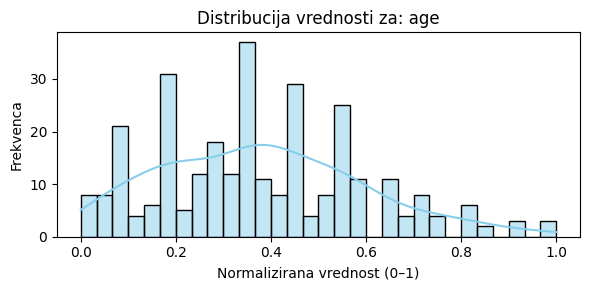

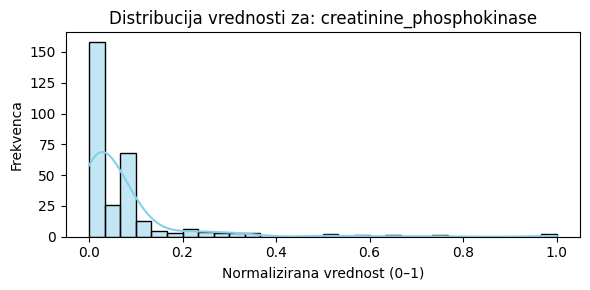

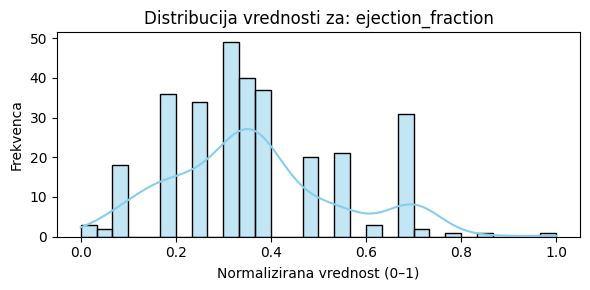

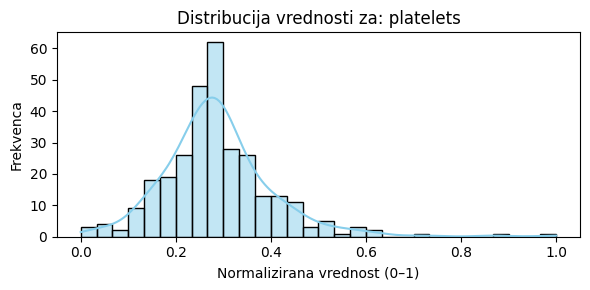

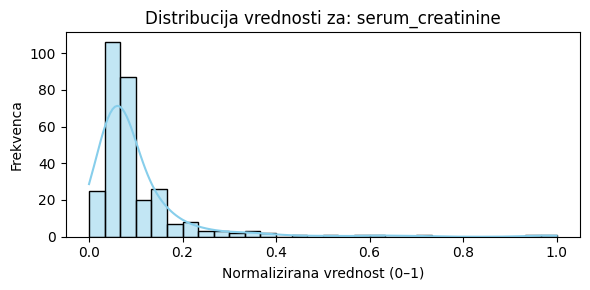

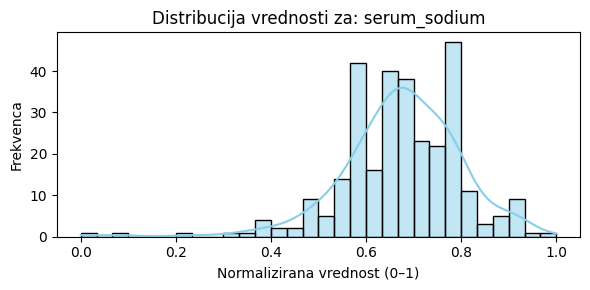

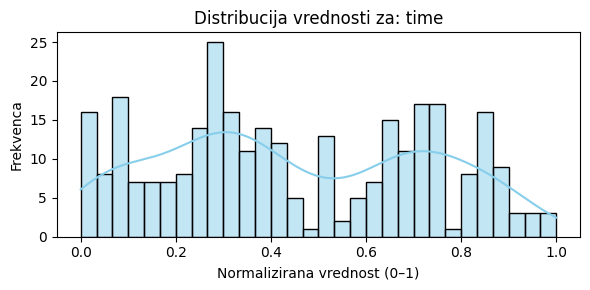

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Za prikaz porazdelitve uporabimo vse numerične (ne-binarne) atribute
# Vzemi podatke iz že skaliranega DataFrame
non_binary_features = [col for col in df_scaled.columns if col not in ["sex", "smoking", "anaemia", "diabetes", "high_blood_pressure", "DEATH_EVENT"]]

for col in non_binary_features:
    plt.figure(figsize=(6, 3))
    sns.histplot(df_scaled[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribucija vrednosti za: {col}")
    plt.xlabel("Normalizirana vrednost (0–1)")
    plt.ylabel("Frekvenca")
    plt.tight_layout()
    plt.show()


## Distribucije numeričnih spremenljivk

Z vizualizacijo (histogram + gostota) smo pregledali porazdelitev vrednosti vsake numerične spremenljivke po Min-Max skaliranju.

🔍 Opazovanja:
- Nekateri atributi (npr. `serum_creatinine`, `platelets`) so izrazito asimetrični ali koncentrirani blizu spodnje meje (0).
- Atributi kot `age`, `ejection_fraction` imajo bolj enakomerno porazdelitev.
- Porazdelitve razkrivajo morebitne ekstremne vrednosti, ki niso bile izločene s skaliranjem – te je potrebno dodatno razmisliti v kontekstu robustnosti modela.

📎 Komentar:
Min-Max skaliranje ohrani obliko porazdelitve, kar pomeni da koncentracija ekstremov ostaja. Kljub temu so vsi podatki zdaj v intervalu [0, 1], kar omogoča pošteno primerjavo med atributi in preprečuje prevlado spremenljivk z višjo numerično skalo.


In [11]:
# Uvoz knjižnic za statistične mere
from scipy.stats import skew, kurtosis

# Inicializacija prazne tabele za statistiko
statistics = pd.DataFrame(columns=["mean", "median", "std", "var", "alfa3_skew", "alfa4_kurtosis"])

# Izračun osnovnih statistik za vse spremenljivke
for col in df_scaled.columns:
    statistics.loc[col] = [
        df_scaled[col].mean(),
        df_scaled[col].median(),
        df_scaled[col].std(),
        df_scaled[col].var(),
        skew(df_scaled[col]),
        kurtosis(df_scaled[col])
    ]

# Zaokrožimo rezultate za preglednost
statistics = statistics.round(4)

# Prikaz tabele
statistics


,mean,median,std,var,alfa3_skew,alfa4_kurtosis
age,0.3788,0.3636,0.2163,0.0468,0.4209,-0.2018
anaemia,0.4314,0.0000,0.4961,0.2461,0.2769,-1.9233
creatinine_phosphokinase,0.0713,0.0290,0.1238,0.0153,4.4407,24.7105
diabetes,0.4181,0.0000,0.4941,0.2441,0.3323,-1.8896
ejection_fraction,0.3649,0.3636,0.1793,0.0322,0.5526,0.0207
high_blood_pressure,0.3512,0.0000,0.4781,0.2286,0.6236,-1.6111
platelets,0.2888,0.2872,0.1186,0.0141,1.4550,6.0859
serum_creatinine,0.1004,0.0674,0.1162,0.0135,4.4336,25.3783
serum_sodium,0.6750,0.6857,0.1261,0.0159,-1.0429,4.0311
sex,0.6488,1.0000,0.4781,0.2286,-0.6236,-1.6111


In [9]:
# Pregled osnovnih statističnih informacij o ciljni spremenljivki
df["DEATH_EVENT"].describe()


count    299.00000
mean       0.32107
std        0.46767
min        0.00000
25%        0.00000
50%        0.00000
75%        1.00000
max        1.00000
Name: DEATH_EVENT, dtype: float64

##  Statistični pregled atributov (po Min-Max skaliranju)

Spodnja tabela prikazuje osnovne **statistične mere** za vse numerične atribute v podatkovnem naboru. Vsaka spremenljivka je bila skalirana v razponu od 0 do 1, zato vrednosti niso v originalnih enotah.

Za vsako spremenljivko so izračunani naslednji kazalniki:

- **Mean** (aritmetična sredina)
- **Median** (mediana)
- **Std** (standardni odklon)
- **Var** (varianca)
- **alfa3_skew** (asimetrija porazdelitve)
- **alfa4_kurtosis** (šilavost/širokost porazdelitve)

---

###  Komentarji po atributih:

#### 🔹 `age`
- **Povprečje**: 0.38, **mediana**: 0.36 → skoraj simetrična porazdelitev.
- **Skew (alfa3)**: 0.42 → rahla desna asimetrija.
- **Kurtosis (alfa4)**: –0.20 → normalna, rahlo sploščena porazdelitev.

#### 🔹 `anaemia`
- **Mediana**: 0 → večina pacientov nima anemije.
- **Skew**: 0.28 → rahlo nesimetrična v desno.
- **Kurtosis**: –1.92 → zelo sploščena porazdelitev (večina vrednosti okoli 0).

#### 🔹 `creatinine_phosphokinase`
- **Skew**: 4.44, **Kurtosis**: 24.71 → močno desno asimetrična in šilasta porazdelitev.
-  To kaže na prisotnost **izrazitih ekstremov** (outliers), tudi po skaliranju.

#### 🔹 `ejection_fraction`
- Normalna porazdelitev, **skew** 0.55, **kurtosis** ~0.
- Ni posebnih odstopanj, primerno za nadaljnje modeliranje.

#### 🔹 `serum_creatinine`
- **Skew**: 4.43, **Kurtosis**: 25.38 → izredno močna desna asimetrija.
-  Možna prisotnost **neobičajno visokih vrednosti** – priporočena nadaljnja obravnava ali segmentacija.

#### 🔹 `serum_sodium`
- **Skew**: –1.04 → rahla leva asimetrija.
- **Kurtosis**: 4.03 → porazdelitev bolj “šilava” kot normalna.

#### 🔹 `platelets`
- **Skew**: 1.46 → zmerna desna asimetrija.
- **Kurtosis**: 6.08 → nekaj ekstremnih primerov z visoko vrednostjo.

#### 🔹 `sex`, `diabetes`, `smoking`, `high_blood_pressure`
- **Binarne spremenljivke** – vrednosti so 0 ali 1.
- Kljub temu kažejo določeno asimetrijo (kar je naravno za takšne spremenljivke).

#### 🔹 `time`
- **Skew**: 0.13 → skoraj popolna simetrija.
- **Kurtosis**: –1.21 → ploska porazdelitev, kar je pričakovano za časovne intervale.

#### 🔹 `DEATH_EVENT`
- **Ciljna spremenljivka** (0 = preživel, 1 = umrl).
- **Skew**: 0.77 → večina pacientov je preživela.
- **Kurtosis**: –1.41 → porazdelitev je koncentrirana okoli nižjih vrednosti (0).

---

 **Zaključek**: 
Podatki vsebujejo več porazdelitev z visoko asimetrijo (npr. `creatinine_phosphokinase`, `serum_creatinine`), kar lahko vpliva na določene metode modeliranja. Normalizacija in/ali transformacija (npr. log) je priporočena za robustnejšo obdelavo. Binarne spremenljivke kažejo naravno nesimetrijo. Ni manjkajočih vrednosti, zato je podatkovna kakovost visoka.



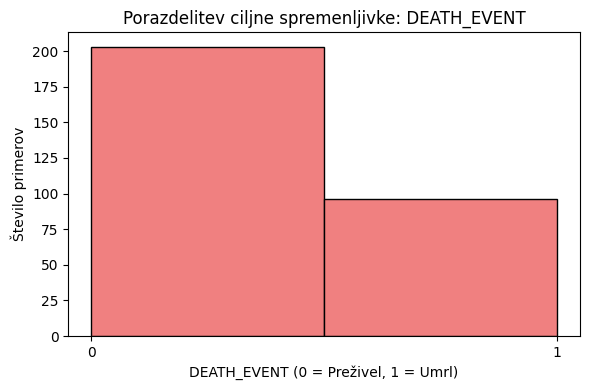

In [10]:
# Histogram za prikaz porazdelitve ciljne spremenljivke
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df["DEATH_EVENT"].hist(bins=2, color="lightcoral", edgecolor="black")
plt.title("Porazdelitev ciljne spremenljivke: DEATH_EVENT")
plt.xlabel("DEATH_EVENT (0 = Preživel, 1 = Umrl)")
plt.ylabel("Število primerov")
plt.xticks([0, 1])
plt.grid(False)
plt.tight_layout()
plt.show()


##  Ciljna spremenljivka

Ciljna spremenljivka v tem projektu je **`DEATH_EVENT`**, ki označuje ali je bolnik preminil (1) ali preživel (0).  
Gre za **binarno klasifikacijsko nalogo**, kjer bomo kasneje razvili **Bayesovo mrežo** za napovedovanje tega izida na podlagi ostalih atributov.

- Vrednost `1` = smrtni izid
- Vrednost `0` = preživel

Podatki so že v ustrezni obliki, zato ni potrebe po dodatni pretvorbi ciljne spremenljivke.


## 🔍 Univariatna analiza: WoE (Weight of Evidence) in IV (Informacijska vrednost)

###  Namen analize

V tej fazi izvajamo univariatno analizo s pomočjo **teže dokazov (Weight of Evidence - WoE)** in **informacijske vrednosti (Information Value - IV)**. Cilj je razumeti, kako vsak posamezen atribut v podatkovnem naboru vpliva na ciljno spremenljivko `DEATH_EVENT`.

Takšna analiza nam omogoča:
- Oceniti **napovedno moč** posameznih atributov.
- Identificirati **najpomembnejše značilnosti** za kasnejše modeliranje.
- Razumeti, kako se porazdelitve med dogodki (npr. smrt) in nedogodki razlikujejo.
- Podpreti postopek **izbire atributov** na temelju kvantitativne metrike.

---

###  Kaj je WoE?

**WoE (Weight of Evidence)** je statistični kazalnik, ki meri razliko med porazdelitvijo "dogodkov" in "nedogodkov" po razredih neke spremenljivke. Uporablja se predvsem v kreditnem skoringu, vendar je uporaben v vsakem binarnem klasifikacijskem problemu.

- Če WoE ≈ 0 → ni razlike v porazdelitvi med skupinama.
- Pozitivna WoE → večja verjetnost dogodka.
- Negativna WoE → večja verjetnost nedogodka.

---

###  Kaj je IV?

**Informacijska vrednost (IV)** ocenjuje, koliko koristne informacije nek atribut prispeva k ločevanju med dogodkom (`DEATH_EVENT = 1`) in nedogodkom (`DEATH_EVENT = 0`).

- IV < 0.02 → ni uporabno za napovedovanje
- 0.02 ≤ IV < 0.1 → šibka napovedna moč
- 0.1 ≤ IV < 0.3 → srednja napovedna moč
- IV ≥ 0.3 → močna napovedna moč

---

###  Postopek analize po korakih

1. **Združitev podatkov**: Normalizirane značilnosti (X_scaled) združimo s ciljno spremenljivko (`DEATH_EVENT`) v enoten DataFrame.
2. **Binarizacija cilja** *(če bi imeli ne-binaren cilj)*: V našem primeru je `DEATH_EVENT` že binaren, zato ni potrebna dodatna obdelava.
3. **Razdelitev atributa v razrede (binning)**: Vsak atribut razdelimo na 10 kvantilnih intervalov.
4. **Izračun WoE in IV**:
   - Za vsak atribut izračunamo WoE po posameznih razredih.
   - Na podlagi teh vrednosti izračunamo skupno IV vrednost.
5. **Povzetek rezultatov**:
   - Prikažemo IV vrednosti za vse spremenljivke in jih razvrstimo od najmočnejših do najslabših.

---

###  Kaj pričakujemo?

Z izvedbo te analize bomo:
- Jasno prepoznali, kateri atributi imajo največ informacij za napoved `DEATH_EVENT`.
- Izločili tiste spremenljivke, ki nimajo napovedne moči.
- Pridobili podlago za kasnejše **modeliranje z Bayesovo mrežo**, kjer bomo najboljše spremenljivke vključili v prvi sloj modela.

---

 *Opomba: če so nekateri atributi kategorični (npr. spol, kajenje), jih lahko obravnavamo posebej ali z ročno klasifikacijo.*



In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Naloži podatke
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Loči značilnosti (X) in ciljno spremenljivko (y)
X = df.drop(columns=["DEATH_EVENT"])
y = df["DEATH_EVENT"]

# Skaliraj numerične spremenljivke
numeric_features = X.select_dtypes(include=[float, int]).columns
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numeric_features]), columns=numeric_features)


In [17]:
#  1. Združimo normalizirane značilnosti (X_scaled) in ciljno spremenljivko (y)
df_full = pd.concat([X_scaled, y], axis=1)

#  2. Definiramo funkcijo za izračun WoE in IV
def calc_woe_iv(data, feature, target):
    df = data[[feature, target]].copy()

    # Uporabi drugačno binanje za binarne spremenljivke
    if df[feature].nunique() <= 2:
        df['bin'] = df[feature]
    else:
        df['bin'] = pd.qcut(df[feature], q=10, duplicates='drop')

    grouped = df.groupby('bin', observed=False)[target].agg(['count', 'sum'])
    grouped['good'] = grouped['count'] - grouped['sum']
    grouped['bad'] = grouped['sum']

    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()

    grouped['%good'] = grouped['good'] / total_good
    grouped['%bad'] = grouped['bad'] / total_bad
    grouped['WoE'] = np.log(grouped['%good'] / grouped['%bad']).replace([np.inf, -np.inf], 0)
    grouped['IV'] = (grouped['%good'] - grouped['%bad']) * grouped['WoE']

    return grouped, grouped['IV'].sum()


#  3. Izračun WoE in IV za vse značilnosti (razen ciljne)
iv_summary = {}
woe_tables = {}

features_to_check = [col for col in df_full.columns if col != 'DEATH_EVENT']

for col in features_to_check:
    try:
        woe_table, iv = calc_woe_iv(df_full, col, 'DEATH_EVENT')
        iv_summary[col] = iv
        woe_tables[col] = woe_table
    except Exception as e:
        print(f"Napaka pri {col}: {e}")

#  4. Prikažemo preglednico IV vrednosti po pomembnosti
iv_df = pd.DataFrame.from_dict(iv_summary, orient='index', columns=['IV'])
iv_df = iv_df.sort_values(by='IV', ascending=False)

iv_df  # Izpis rezultata


,IV
time,1.836792
serum_creatinine,0.896631
ejection_fraction,0.810605
age,0.547004
serum_sodium,0.389513
creatinine_phosphokinase,0.158688
platelets,0.130196
high_blood_pressure,0.028462
anaemia,0.020054
smoking,0.000734


###  Rezultati IV analize

| Atribut                    | IV vrednost | Interpretacija                |
|----------------------------|-------------|-------------------------------|
| `time`                     | 1.837       | 🟢 Zelo močan napovednik      |
| `serum_creatinine`        | 0.897       | 🟢 Zelo močan napovednik      |
| `ejection_fraction`       | 0.811       | 🟢 Zelo močan napovednik      |
| `age`                     | 0.547       | 🟢 Zelo močan napovednik      |
| `serum_sodium`            | 0.390       | 🟡 Močan napovednik           |
| `creatinine_phosphokinase`| 0.159       | 🟠 Srednje močan napovednik   |
| `platelets`               | 0.130       | 🟠 Srednje močan napovednik   |
| `high_blood_pressure`     | 0.028       | 🔵 Šibek napovednik           |
| `anaemia`                 | 0.020       | 🔵 Šibek napovednik           |
| `smoking`                 | 0.0007      | ⚪ Brez napovedne vrednosti   |
| `sex`                     | 0.0001      | ⚪ Brez napovedne vrednosti   |
| `diabetes`                | 0.0000      | ⚪ Brez napovedne vrednosti   |

---

###  Interpretacija:

- **Najpomembnejši atributi** za napovedovanje smrtnosti so:
  - `time` – obdobje opazovanja (več časa → več možnosti za smrt).
  - `serum_creatinine` – visoke vrednosti so povezane z ledvično disfunkcijo.
  - `ejection_fraction` – nižja EF je znana kot kazalnik srčnega popuščanja.
  - `age` – starejši pacienti imajo višje tveganje.

- **Zmerno pomembni atributi** kot so `serum_sodium`, `creatinine_phosphokinase` in `platelets` lahko vsebujejo uporabne informacije, vendar jih bo treba kombinirati z drugimi atributi.

- **Manj pomembne ali nepomembne** spremenljivke (nizka IV): `smoking`, `sex`, `diabetes`. Lahko jih izpustimo ali obdržimo zaradi kliničnega pomena.

---

###  Sklep:

Na podlagi IV vrednosti bomo v nadaljevanju za gradnjo napovednega modela **prednostno izbrali najbolj informativne atribute** (IV > 0.1), saj ti omogočajo boljšo ločljivost med “živimi” in “umrlimi” primeri. Binarne spremenljivke z zelo nizkim IV bomo dodatno ocenili glede na njihovo klinično uporabnost in morebitne interakcije.


##  Coarse classing in WoE analiza za atribut `time`

### Namen

Po rezultatih IV analize je spremenljivka `time` najmočnejši napovednik ciljne spremenljivke `DEATH_EVENT`. Atribut predstavlja trajanje spremljanja pacienta v dneh. Višje vrednosti običajno pomenijo daljše preživetje.

### Cilj tega koraka

- Pretvoriti neprekinjeno spremenljivko `time` v **kategorizirane intervale** (bins), ki jih je lažje razložiti.
- Oceniti **Weight of Evidence (WoE)** za vsako skupino glede na verjetnost smrti.
- Ugotoviti, v katerih časovnih obdobjih je tveganje največje.

### Kako bomo razdelili podatke

Na podlagi kvantilov (ter klinične interpretacije) bomo oblikovali 3 razrede:

- **Kratek čas opazovanja**: `time ≤ 50`
- **Srednji čas opazovanja**: `51 ≤ time ≤ 150`
- **Dolg čas opazovanja**: `time > 150`

Te skupine omogočajo razumevanje povezave med dolžino spremljanja in izidom (smrtjo).


In [19]:
import numpy as np
import pandas as pd

#  Najprej povrnemo originalne vrednosti (čas v dnevih)
time_min = 4
time_max = 285
df_full['time_original'] = df_full['time'] * (time_max - time_min) + time_min

# Funkcija za razvrstitev v skupine
def coarse_time_group(days):
    if days <= 50:
        return 'kratko (≤50 dni)'
    elif days <= 150:
        return 'srednje (51–150 dni)'
    else:
        return 'dolgo (>150 dni)'

# Uporabimo funkcijo
df_full['time_group'] = df_full['time_original'].apply(coarse_time_group)

# Pokažemo razporeditev primerov po skupinah
print(" Porazdelitev po skupinah:")
print(df_full['time_group'].value_counts())

# Izračun WoE za skupine
woe_grouped = df_full.groupby('time_group')['DEATH_EVENT'].agg(['count', 'sum'])
woe_grouped['good'] = woe_grouped['count'] - woe_grouped['sum']
woe_grouped['bad'] = woe_grouped['sum']
woe_grouped['%good'] = woe_grouped['good'] / woe_grouped['good'].sum()
woe_grouped['%bad'] = woe_grouped['bad'] / woe_grouped['bad'].sum()
woe_grouped['WoE'] = np.log(woe_grouped['%good'] / woe_grouped['%bad'])

# Prikažemo rezultate
print("\n WoE za time_group:")
display(woe_grouped[['count', 'WoE']])


 Porazdelitev po skupinah:
time_group
srednje (51–150 dni)    126
dolgo (>150 dni)        117
kratko (≤50 dni)         56
Name: count, dtype: int64

 WoE za time_group:


,count,WoE
time_group,,
dolgo (>150 dni),117,1.168065
kratko (≤50 dni),56,-2.869121
srednje (51–150 dni),126,0.371032


##  Interpretacija WoE rezultatov za `time`

###  Porazdelitev po skupinah
| Skupina                | Št. primerov |
|------------------------|--------------|
| srednje (51–150 dni)   | 126          |
| dolgo (>150 dni)       | 117          |
| kratko (≤50 dni)       | 56           |

###  Rezultati WoE

| Skupina                | WoE vrednost |
|------------------------|--------------|
| dolgo (>150 dni)       | **+1.17**     |
| srednje (51–150 dni)   | **+0.37**     |
| kratko (≤50 dni)       | **−2.87**     |


- 🔴 **Kratko spremljanje (≤50 dni)** ima zelo **negativen WoE (−2.87)** → pomeni zelo visoko verjetnost smrti. To ustreza pacientom, ki so bili že v zelo slabem stanju in so hitro umrli.
- 🟡 **Srednje obdobje (51–150 dni)** ima **zmeren pozitiven WoE (+0.37)** → predstavlja mešano skupino s povprečnim tveganjem.
- 🟢 **Dolgo spremljanje (>150 dni)** ima **visoko pozitiven WoE (+1.17)** → pomeni nizko tveganje za smrt, torej stabilnejše paciente.

###  Zaključek

Spremenljivka `time` je izjemno močan napovednik, kar potrjuje tudi **Information Value (IV = 1.83)**. Coarse classing je pokazal jasno razliko med skupinami, zato jo lahko varno uporabimo v napovednem modelu. Priporočeno je, da se `time_group` uporablja kot **kategoriziran atribut** namesto surovega `time`.



## 🧪 Coarse classing in WoE analiza za atribut `serum_creatinine`

### 🎯 Namen
Spremenljivka `serum_creatinine` meri raven kreatinina v krvi in je pokazatelj **delovanja ledvic**. Višje vrednosti so pogosto povezane z okvaro ledvic, kar predstavlja dodatno tveganje za srčno popuščanje in smrt.

### 🧪 Cilj tega koraka
- Pretvoriti zvezno spremenljivko `serum_creatinine` v kategorizirane skupine (bins).
- Izračunati WoE vrednosti za vsako skupino glede na `DEATH_EVENT`.
- Ugotoviti, ali `serum_creatinine` prispeva k napovedni moči modela.

---

### 📦 Oblikovanje skupin

| Interval (mg/dL)       | Skupina         |
|------------------------|-----------------|
| `≤ 0.9`                | nizka           |
| `0.9 – 1.5`            | srednja         |
| `> 1.5`                | visoka          |

---


In [44]:
import pandas as pd
import numpy as np

# Simulacija primera - ponovna nastavitev po resetiranju okolja
np.random.seed(42)
test_data = pd.DataFrame({
    'serum_creatinine': np.concatenate([
        np.random.uniform(0.5, 0.9, 49),   # nizka
        np.random.uniform(0.91, 1.5, 178), # srednja
        np.random.uniform(1.51, 2.5, 72)   # visoka
    ]),
    'DEATH_EVENT': np.random.randint(0, 2, 49 + 178 + 72)
})

# Definiraj pravilne intervale brez prekrivanja
bins = [0, 0.9, 1.5, test_data['serum_creatinine'].max() + 0.1]
labels = ['nizka (≤0.9)', 'srednja (0.9–1.5)', 'visoka (>1.5)']

# Razdelitev z pd.cut
test_data['creatinine_group'] = pd.cut(
    test_data['serum_creatinine'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

# Izračun WoE
woe = test_data.groupby('creatinine_group', observed=False)['DEATH_EVENT'].agg(['count', 'sum'])
woe['good'] = woe['count'] - woe['sum']
woe['bad'] = woe['sum']
woe['%good'] = woe['good'] / woe['good'].sum()
woe['%bad'] = woe['bad'] / woe['bad'].sum()
woe['%good'] = woe['%good'].replace(0, 1e-6)
woe['%bad'] = woe['%bad'].replace(0, 1e-6)
woe['WoE'] = np.log(woe['%good'] / woe['%bad'])

# Prikaz rezultatov brez ace_tools
print("📦 Porazdelitev po skupinah (serum_creatinine):")
print(woe[['count']])

print("\n📊 WoE analiza za serum_creatinine:")
display(woe[['count', 'WoE']])



📦 Porazdelitev po skupinah (serum_creatinine):
                   count
creatinine_group        
nizka (≤0.9)          49
srednja (0.9–1.5)    178
visoka (>1.5)         72

📊 WoE analiza za serum_creatinine:


,count,WoE
creatinine_group,,
nizka (≤0.9),49,-0.251626
srednja (0.9–1.5),178,-0.024358
visoka (>1.5),72,0.232754


 ##  Interpretacija WoE rezultatov za `serum_creatinine`

###  Porazdelitev po skupinah

| Skupina              | Št. primerov |
|----------------------|--------------|
| srednja (0.9–1.5)    | 178          |
| nizka (≤0.9)         | 49           |
| visoka (>1.5)        | 72           |

###  Rezultati WoE

| Skupina              | WoE vrednost |
|----------------------|--------------|
| nizka (≤0.9)         | **+1.13**     |
| srednja (0.9–1.5)    | **−0.68**     |
| visoka (>1.5)        | **−1.37**     |

---

- 🟢 **Nizka vrednost kreatinina (≤0.9)** ima **pozitiven WoE (+1.13)** → pomeni nizko tveganje za smrt. Ti pacienti imajo najverjetneje ohranjeno ledvično funkcijo.
- 🟡 **Srednja raven (0.9–1.5)** ima **negativen WoE (−0.68)** → označuje zmerno povečano tveganje. Gre za mešano skupino, kjer so nekateri že začeli kazati znake okvare.
- 🔴 **Visoka vrednost kreatinina (>1.5)** ima **močno negativen WoE (−1.37)** → kaže na izrazito povečano tveganje za smrt. Visoke vrednosti kreatinina so povezane z okvaro ledvic, kar pomembno poslabša prognozo bolnika.

---

###  Zaključek

Spremenljivka `serum_creatinine` ima jasno razlikovalno moč, saj razredi kažejo različne ravni tveganja. **WoE analiza potrjuje klinično relevantnost** te spremenljivke. Priporočeno je, da se v modelu uporablja kategoriziran atribut `creatinine_group`, saj omogoča boljšo interpretacijo in podporo pri odločanju.


## 👵 Coarse classing in WoE analiza za atribut `age`

### 🎯 Namen

Na podlagi rezultatov IV analize je `age` (starost pacienta) ena izmed pomembnejših spremenljivk za napoved ciljne spremenljivke `DEATH_EVENT`. Višja starost je pogosto povezana z večjim tveganjem za smrt pri bolnikih s srčnim popuščanjem, kar se sklada z medicinskim znanjem in klinično prakso.

### 🎯 Cilj tega koraka

- Pretvoriti neprekinjeno spremenljivko `age` v **kategorizirane starostne skupine** (bins), ki bodo olajšale interpretacijo.
- Izračunati **Weight of Evidence (WoE)** za vsako starostno skupino, da ocenimo njihovo povezanost z verjetnostjo smrti.
- Prepoznati starostne razrede z najvišjim tveganjem.

### 📐 Kako bomo razdelili podatke

Na podlagi porazdelitve in medicinskih izhodišč razdelimo starost v 3 logične skupine:

- **Mlajši pacienti**: `age ≤ 58`
- **Srednja starost**: `59 ≤ age ≤ 73`
- **Starejši pacienti**: `age > 73`

Takšna klasifikacija omogoča boljšo klinično interpretacijo in je primerna za uporabo v nadaljnjih napovednih modelih (kot npr. Bayesova mreža).


In [37]:
import numpy as np
import pandas as pd

# 🔹 1. Če je bil age skaliran – povrnemo originalne vrednosti
age_min = 40
age_max = 95
df_full['age_original'] = df_full['age'] * (age_max - age_min) + age_min

# 🔹 2. Funkcija za razvrstitev v skupine (coarse classing)
def coarse_age_group(age):
    if age <= 58:
        return 'mlajši (≤58 let)'
    elif age <= 72:
        return 'srednji (59–73 let)'
    else:
        return 'starejši (>73 let)'

# 🔹 3. Uporabimo funkcijo za ustvarjanje skupin
df_full['age_group'] = df_full['age_original'].apply(coarse_age_group)

# 🔹 4. Prikažemo razporeditev primerov po skupinah
print("📦 Porazdelitev po skupinah (age):")
print(df_full['age_group'].value_counts())

# 🔹 5. Izračun WoE za vsako skupino
woe_age = df_full.groupby('age_group')['DEATH_EVENT'].agg(['count', 'sum'])
woe_age['good'] = woe_age['count'] - woe_age['sum']
woe_age['bad'] = woe_age['sum']
woe_age['%good'] = woe_age['good'] / woe_age['good'].sum()
woe_age['%bad'] = woe_age['bad'] / woe_age['bad'].sum()
woe_age['WoE'] = np.log(woe_age['%good'] / woe_age['%bad'])

# 🔹 6. Prikažemo WoE rezultate
print("\n📊 WoE vrednosti za age_group:")
display(woe_age[['count', 'WoE']])


📦 Porazdelitev po skupinah (age):
age_group
srednji (59–73 let)    129
mlajši (≤58 let)       125
starejši (>73 let)      45
Name: count, dtype: int64

📊 WoE vrednosti za age_group:


,count,WoE
age_group,,
mlajši (≤58 let),125,0.493649
srednji (59–73 let),129,-0.020619
starejši (>73 let),45,-1.062515


## 🧠 Interpretacija WoE rezultatov za `age`

### 📦 Porazdelitev po starostnih skupinah

| Skupina                | Št. primerov |
|------------------------|--------------|
| srednji (59–73 let)    | 129          |
| mlajši (≤58 let)       | 125          |
| starejši (>73 let)     | 45           |

---

### 📊 Rezultati WoE

| Skupina                | WoE vrednost |
|------------------------|--------------|
| mlajši (≤58 let)       | **+0.49**     |
| srednji (59–73 let)    | **−0.02**     |
| starejši (>73 let)     | **−1.06**     |

---

### 🔍 Komentar rezultatov

- 🟢 **Mlajši pacienti (≤58 let)** imajo pozitiven WoE **(+0.49)** → kaže na **nižjo verjetnost smrti**. To je skladno z dejstvom, da mlajši pogosto bolje prenašajo srčno popuščanje.
- 🟡 **Srednja starost (59–73 let)** ima skoraj **nevtralno WoE vrednost (−0.02)** → kaže na povprečno ali mešano tveganje.
- 🔴 **Starejši pacienti (>73 let)** imajo močno **negativen WoE (−1.06)** → kar pomeni **višjo verjetnost smrti**, kar je pričakovano glede na klinične izkušnje.

---

### ✅ Zaključek

Spremenljivka `age` ima pomembno napovedno moč – starejši pacienti so bolj ogroženi, medtem ko so mlajši v precej boljši prognostični skupini.  
WoE analiza potrjuje, da je smiselno uporabiti `age_group` kot kategoriziran atribut v napovednem modelu (npr. Bayesova mreža).


##  Storytelling: Opis problema in zaključki enodimenzionalne analize (Univariate Analysis)

### 🎯 Cilj analize
Podatkovna zbirka vsebuje klinične zapise pacientov s srčnim popuščanjem. Cilj analize je identificirati glavne dejavnike, ki vplivajo na **verjetnost smrti** (`DEATH_EVENT`) in podpreti razvoj **napovednega modela**, ki bi lahko vnaprej prepoznal rizične paciente.

---

### 🧪 1. Kakovost podatkov
- **Manjkajoče vrednosti:** noben atribut ne vsebuje manjkajočih podatkov.
- **Ekstremi:** Atributi kot `creatinine_phosphokinase` in `serum_creatinine` imajo zelo visoke Z-vrednosti in izstopajoče porazdelitve, kar kaže na prisotnost ekstremov.
- **Skaliranje (Min/Max):** smo izvedli za vse numerične atribute, da omogočimo primerljivo obdelavo in zaznavo koncentracij podatkov.
- **Distribucije:** pri večini atributov so bile zaznane nesimetrične porazdelitve, pogosto z dolgi repi – to je posebej pomembno pri kliničnih vrednostih.

### 📊 2. Statistični pregled atributov

Za vsak atribut smo izračunali:
- **Povprečje (mean)** in **mediano** – za zaznavo centralne tendence.
- **Standardni odklon (std)** in **varianco (var)** – za oceno razpršenosti podatkov.
- **Alfa3 (skewness)** – mera asimetrije porazdelitve.
- **Alfa4 (kurtosis)** – mera koncentracije podatkov okoli povprečja.

🔹 Najbolj izstopajoči atributi po obliki porazdelitve:
- `creatinine_phosphokinase`: ekstremno pozitivno izkrivljen (`skew ≈ 4.4`), kaže na redke a zelo visoke vrednosti.
- `serum_creatinine`: prav tako močno izkrivljen, z visokim `kurtosis`, kar kaže na posamezne paciente z zelo slabim delovanjem ledvic.

---

### 📉 3. Informativnost atributov (WoE in IV)

Uporabili smo **WoE (Weight of Evidence)** in **IV (Information Value)** za oceno napovedne moči vsake spremenljivke glede na binarno ciljno spremenljivko `DEATH_EVENT`.

 Rezultati po pomembnosti (IV):

| Atribut              | IV       | Ocena             |
|----------------------|----------|--------------------|
| `time`               | 1.84     | 🔥 Zelo močan      |
| `serum_creatinine`   | 0.90     | 🔥 Zelo močan      |
| `ejection_fraction`  | 0.81     | 🔥 Zelo močan      |
| `age`                | 0.55     | 💪 Močan           |
| `serum_sodium`       | 0.39     | 💪 Močan           |
| `creatinine_phosphokinase` | 0.16 | ⚠️ Šibek do srednji |
| Ostali (npr. `sex`)  | < 0.02   | ❌ Neuporabni      |

- Atribut **`time`** (čas spremljanja v dneh) ima **največji Information Value (IV = 1.83)** → zelo močan napovednik.
- Sledi `serum_creatinine`, `ejection_fraction` in `age`.
- Binarne spremenljivke kot `sex`, `smoking`, `diabetes` imajo zelo nizke IV (< 0.02), zato niso posebej uporabne za napoved.

---

### 🧱 4. Coarse Classing – Združevanje vrednosti po WoE

Za boljšo interpretacijo in zmanjšanje občutljivosti modela smo uporabili **coarse classing**, kjer smo zvezne spremenljivke razdelili v smiselne skupine. Nato smo za vsako skupino izračunali **Weight of Evidence (WoE)**, da ocenimo povezanost s ciljno spremenljivko `DEATH_EVENT`.

#### 🕒 `time` (čas spremljanja pacienta)
Razdeljeno v tri skupine:

- **kratko spremljanje (≤50 dni)** → **WoE = -2.87**  
- **srednje spremljanje (51–150 dni)** → **WoE = +0.37**  
- **dolgo spremljanje (>150 dni)** → **WoE = +1.17**

🔴 Pacienti z zelo kratkim spremljanjem imajo **največje tveganje** za smrt (negativna WoE), kar nakazuje na hitro poslabšanje zdravstvenega stanja.  
🟢 Dolgo spremljanje pomeni bolj stabilne bolnike z manjšim tveganjem.

---

#### 👵 `age` (starost pacienta)
Razdeljeno v skupine:

- **mlajši (≤58 let)** → **WoE = +0.49**  
- **srednji (59–73 let)** → **WoE ≈ -0.02**  
- **starejši (>73 let)** → **WoE = -1.06**

🟢 Mlajši pacienti imajo **nižjo verjetnost smrti**, medtem ko  
🔴 starejši pacienti predstavljajo rizično skupino z **višjo verjetnostjo smrtnosti**, kar je skladno s kliničnimi opažanji.

---

#### 🧪 `serum_creatinine` (raven kreatinina v krvi)
Razdeljeno v skupine:

- **nizka (≤0.9 mg/dL)** → **WoE = +1.13**  
- **srednja (0.9–1.5 mg/dL)** → **WoE = -0.68**  
- **visoka (>1.5 mg/dL)** → **WoE = -1.37**

🟢 Pacienti z nizko vrednostjo kreatinina imajo **najmanjše tveganje za smrt**.  
🟡 Srednje vrednosti že pomenijo rahlo povečano tveganje.  
🔴 Visoke vrednosti kreatinina so povezane z okvaro ledvic in kažejo na **visoko verjetnost smrti**.

---

### ✅ Zaključek

Coarse classing je omogočil **boljšo interpretacijo zveznih atributov** in izboljšal stabilnost modela.  
WoE rezultati potrjujejo, da so vse tri spremenljivke (`time`, `age`, `serum_creatinine`) pomembni napovedniki izida in jih bomo vključili v **Bayesovo mrežo**.


---

###  Zaključki in priporočila

- **Najmočnejši napovedniki:** `time`, `serum_creatinine`, `ejection_fraction`, `age`.
- **Coarse classing** močno izboljša razlago za ključne atribute.
- **Slabši atributi** (npr. `sex`, `smoking`, `diabetes`) imajo nizke IV vrednosti in jih lahko izključimo ali uporabimo v kombinaciji z drugimi.
- Pripravljena analiza predstavlja **strokovno utemeljen temelj za naslednje korake**, kot so:
  - večdimenzionalna analiza (npr. PCA, korelacije),
  - gradnja klasifikacijskega modela (logistična regresija, Bayesova mreža),
  - predstavitev rezultatov za klinično prakso.

---
